In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [59]:
train=pd.read_csv("./churn_prediction_data/train.csv")
test=pd.read_csv("./churn_prediction_data/test.csv")

In [60]:
train["Exited"].value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

## 資料前處理

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
 13  Exited           8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


In [5]:
train.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
train['Surname'].value_counts()

Smith        27
Martin       27
Scott        25
Walker       23
Fanucci      22
             ..
McGuigan      1
McCardle      1
Ifeanacho     1
Morin         1
McCaffrey     1
Name: Surname, Length: 2589, dtype: int64

In [7]:
#train["Geography"] = train["Geography"].map({'France':int(0),'Germany':int(1),'Spain':int(2)}, na_action=None)

In [61]:
#ID取前四個數字
train["ID"]=train['CustomerId'].astype(str).str[:4].astype(int)
#將財務商品整合成兩類，大於2個、少於等於2個
train["is_4"]=train['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
#性別數值化(男生0、女生1)
train['Gender']=train['Gender'].apply(lambda x: 1 if x =="male"  else 0)

In [62]:
#將名字數值化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Surname'].append(test['Surname']))
train["NAME_ID"]=pd.Series(le.transform(train['Surname']))

In [63]:
#選擇重要的特徵
select_data=train[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [64]:
#國家dummy variable
features_dummies=pd.get_dummies(train["Geography"])

In [65]:
#合併資料
#data=select_data
data=pd.concat([select_data, features_dummies],axis=1)

In [66]:
data

,CreditScore,Balance,Tenure,Gender,IsActiveMember,Age,NumOfProducts,France,Germany,Spain
0,720,114051.97,5,0,1,38,2,0,0,1
1,682,62397.41,4,0,0,54,1,1,0,0
2,672,119903.67,5,0,1,31,1,1,0,0
3,592,104257.86,4,0,0,40,1,0,0,1
4,753,120387.73,5,0,1,42,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7995,568,121079.60,6,0,1,35,2,1,0,0
7996,602,145846.07,7,0,0,45,1,0,1,0
7997,679,132810.01,5,0,0,43,1,0,0,1
7998,715,118729.45,4,0,0,38,1,1,0,0


## 切訓練集/測試集

In [67]:
#切割資料
train_data,test_data,train_labels,test_labels=train_test_split(data,train["Exited"],test_size=0.05,stratify=train["Exited"])

In [68]:
train_labels = np.array(train_labels)
train_data =  np.array(train_data)
test_labels= np.array(test_labels)
test_data = np.array(test_data)

## 套入Decision tree預測

In [16]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion='entropy') 
dt.fit(train_data,train_labels) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
dt.score(train_data,train_labels)

0.9997368421052631

In [18]:
dt.score(test_data,test_labels)

0.785

<Figure size 432x288 with 0 Axes>

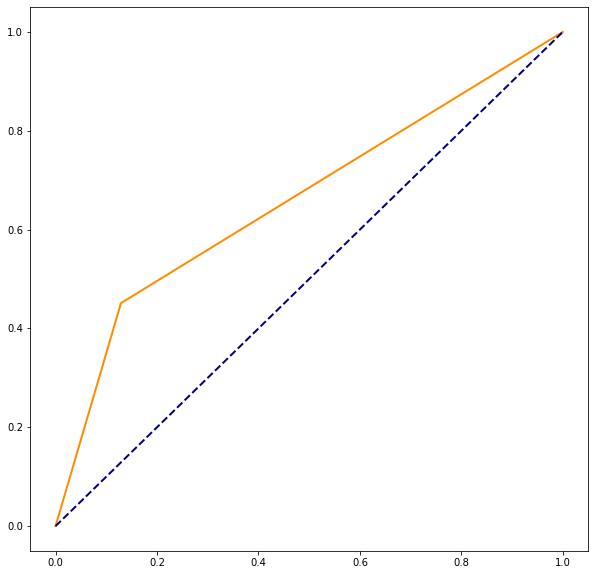

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, dt.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [20]:
roc_auc

0.6611443472925295

# 套入Random forest

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import  ensemble, preprocessing, metrics
forest = ensemble.RandomForestClassifier(max_depth=10,n_estimators=32)
forest.fit(train_data,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=32,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [127]:
forest.score(train_data,train_labels)

0.8960526315789473

In [128]:
forest.score(test_data,test_labels)

0.8775

<Figure size 432x288 with 0 Axes>

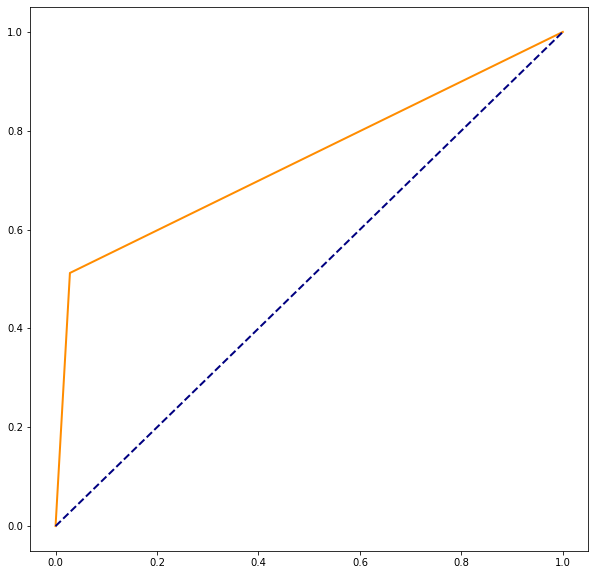

In [129]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, forest.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [130]:
roc_auc

0.7419466175793833

In [131]:
data.columns

Index(['CreditScore', 'Balance', 'Tenure', 'Gender', 'IsActiveMember', 'Age',
       'NumOfProducts', 'France', 'Germany', 'Spain'],
      dtype='object')

In [132]:
forest.feature_importances_

array([0.11170185, 0.1427106 , 0.04168652, 0.        , 0.07356934,
       0.33005689, 0.23897914, 0.01127143, 0.03915771, 0.01086653])

## test資料預測

In [28]:
#test資料前處理
test["ID"]=test['CustomerId'].astype(str).str[:4].astype(int)
test["is_4"]=test['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
test["NAME_ID"]=pd.Series(le.transform(test['Surname']))
test['Gender']=test['Gender'].apply(lambda x: 1 if x =="male"  else 0)

In [29]:
#特徵選擇
select_data=test[["CreditScore","Balance","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [30]:
#特徵dummy
features_dummies=pd.get_dummies(test["Geography"])

In [31]:
#合併資料
data=pd.concat([select_data, features_dummies],axis=1)

In [32]:
#預測結果
forest.predict(data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
#預測為1的比例
sum(forest.predict(data))/2000

0.1275

## 匯出資料

In [34]:
#決策樹
d = {"RowNumber":test.RowNumber,"Exited":forest.predict(data)}
df = pd.DataFrame(d)
#df.to_csv("./output/decision2.csv")

In [35]:
#隨機樹
d = {"RowNumber":test.RowNumber,"Exited":forest.predict(data)}
df = pd.DataFrame(d)
#df.to_csv("./output/random8.csv")